<img src='https://github.com/jeshraghian/snntorch/blob/master/docs/_static/img/snntorch_alpha_w.png?raw=true' width="400">

# UNDER CONSTRUCTION

# snnTorch - Deep Learning with ``snntorch``
## Tutorial 3
### By Jason K. Eshraghian (www.jasoneshraghian.com)

<a href="https://colab.research.google.com/github/jeshraghian/snntorch/blob/tutorials/examples/tutorial_3_FCN.ipynb">
  <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
</a>

# Introduction
In this tutorial, you will:
* Learn how spiking neurons are implemented in a recurrent network
* Understand backpropagation through time, and the associated challenges in SNNs such as target labeling, and the non-differentiability of spikes
* Train a fully-connected network on the static MNIST dataset

<!-- * Implement various backprop strategies:
  * Backpropagation Through Time
  * Truncated-Backpropagation Through Time
  * Real-Time Recurrent Learning -->

>Part of this tutorial was inspired by Friedemann Zenke's extensive work on SNNs. Check out his repo on surrogate gradients [here](https://github.com/fzenke/spytorch), and a favourite paper of mine: E. O. Neftci, H. Mostafa, F. Zenke, [Surrogate Gradient Learning in Spiking Neural Networks: Bringing the Power of Gradient-based optimization to spiking neural networks.](https://ieeexplore.ieee.org/document/8891809) IEEE Signal Processing Magazine 36, 51–63.

As a quick recap, [Tutorial 1](https://colab.research.google.com/github/jeshraghian/snntorch/blob/tutorials/examples/tutorial_1_spikegen.ipynb) explained how to convert datasets into spikes using three encoding mechanisms:
* Rate coding
* Latency coding
* Delta modulation

[Tutorial 2](https://colab.research.google.com/github/jeshraghian/snntorch/blob/tutorials/examples/tutorial_2_neuronal_dynamics.ipynb) showed how to build neural networks using three different leaky integrate-and-fire (LIF) neuron models:
* Lapicque's RC model
* Stein's model
* Spike Response model

In this tutorial, a basic supervised learning algorithm will be implemented. We will use the original static MNIST dataset and train a multi-layer fully-connected spiking neural network using gradient descent to perform image classification. 

If running in Google Colab:
* You may connect to GPU by checking `Runtime` > `Change runtime type` > `Hardware accelerator: GPU`
* Next, install the latest PyPi distribution of snnTorch by clicking into the following cell and pressing `Shift+Enter`.

In [1]:
!pip install snntorch

# 1. A Recurrent Representation of SNNs

The following is a summary of the continuous time-domain representation LIF neurons, and applies the result to develop a recurrent representation that is more suitable for use in recurrent neural networks (RNNs). 

We derived the dynamics of the passive membrane using an RC circuit in the time-domain: 

$$ \tau_{\rm mem} \frac{dU_{\rm mem}(t)}{dt} = -U_{\rm mem}(t) + RI_{\rm syn}(t),$$

where the general solution of this equation is:

$$U_{\rm mem}=I_{\rm syn}(t)R + [U_0 - I_{\rm syn}(t)R]e^{-t/\tau_{\rm mem}}$$

In Lapicque's model, $I_{\rm syn}(t)$ is also the input current, $I_{\rm in}(t)$. 

In Stein's model, a more biologically plausible approach is taken that ensures $I_{\rm syn}(t)$ follows an exponential decay as a function of the input:


$$I_{\rm syn}(t) = \sum_k W_{i,j} S_{in; i,j}(t) e^{-(t-t_k)/\tau_{syn}}\Theta(t-t_k)$$

<center>
<img src='https://github.com/jeshraghian/snntorch/blob/master/docs/_static/img/examples/tutorial3/3_1_stein_decomp.png?raw=true' width="600">
</center>

Stein's model has two exponentially decaying terms: $I_{\rm syn}(t)$ and $U_{\rm mem}(t)$. The ratio between subsequent terms (i.e., decay rate) of $I_{\rm syn}(t)$ is set to $\alpha$, and that of $U_{\rm mem}(t)$ is set to $\beta$:

$$ \alpha = e^{-1/\tau_{\rm syn}}$$

$$ \beta = e^{-1/\tau_{\rm mem}}$$


RNNs will process data sequentially, and so time must be discretised, and the neuron models must be converted into a recursive form. $\alpha$ and $\beta$ can be used to give a recursive representation of Stein's neuron model:

$$I_{\rm syn}[t+1]=\underbrace{\alpha I_{\rm syn}[t]}_\text{decay} + \underbrace{WS_{\rm in}[t+1]}_\text{input}$$

$$U[t+1] = \underbrace{\beta U[t]}_\text{decay} + \underbrace{I_{\rm syn}[t+1]}_\text{input} - \underbrace{R[t+1]}_\text{reset}$$

**Spiking**

If $U[t] > U_{\rm thr}$, then an output spike is triggered: $S_{\rm out}[t] = 1$. Otherwise, $S_{\rm out}[t] = 0$. 

> Note: A variation of this is to set the output spike at the *next* time step to be triggered; i.e., $U[t] > U_{\rm thr} \implies S_{\rm out}[t+1] = 1$. This is the approach taken in snnTorch, and will be explained in following sections.

An alternative way to represent the relationship between $S_{\rm out}$ and $U_{\rm mem}$, which is also used to calculate the gradient in the backward pass, is:

$$S_{\rm out}[t] = \Theta(U_{\rm mem}[t] - U_{\rm thr})$$ 

<center>
<img src='https://github.com/jeshraghian/snntorch/blob/master/docs/_static/img/examples/tutorial3/3_1_stein_decomp.png?raw=true' width="600">
</center>

**Reset**

The reset term is activated only when the neuron triggers a spike. That is to say, if $S_{\rm out}[t]=1$:

  * For `reset_mechanism="subtract"`: $R[t+1]=U_{\rm thr}$ 
  * For `reset_mechanism="zero"`: $R[t+1]=U[t+1]$

> Note: In snnTorch, the reset will also take a one time step delay such that $R[t+1]$ is activated only when $S_{\rm out}[t+1]=1$

The other neurons follow a similar form, which is [detailed in the documentation](https://snntorch.readthedocs.io/en/latest/snntorch.html). The recursive neuron equations can be mapped into computation graphs, where the recurrent connections take place with a delay of a single time step, from the state at time $t$ to the state at time $t+1$. 

<center>
<img src='https://github.com/jeshraghian/snntorch/blob/master/docs/_static/img/examples/tutorial3/3_2_spike_descrip.png?raw=true' width="600">
</center>

An alternative way to represent recurrent models is to unfold the computational graph, in which each component is represented by a sequence of different variables, with one variable per time step. The unfolded form of Stein's model is shown below:

<center>
<img src='https://github.com/jeshraghian/snntorch/blob/master/docs/_static/img/examples/tutorial3/3_2_unrolled.png?raw=true' width="800">
</center>


Up until now, the notation used for all variables have had an association with their electrical meanings. As we move from neuronal dynamics to deep learning, we will slightly modify the notation throughout the rest of the tutorial:

* **Input spike:** $S_{\rm in} \rightarrow X$
* **Input current (weighted spike):** $I_{\rm in} \rightarrow Y$
* **Synaptic current:** $I_{\rm syn} \rightarrow I$
* **Membrane potential:** $U_{\rm mem} \rightarrow U$
* **Output spike:** $S_{\rm out} \rightarrow S$

The benefit of an unrolled graph is that we now have an explicit description of how computations are performed. The process of unfolding illustrates the flow of information forward in time (from left to right) to compute outputs and losses, and backward in time to compute gradients. The more time steps that are simulated, the deeper the graph becomes. 

Conventional RNNs treat $\alpha$ and $\beta$ as learnable parameters. This is also possible for SNNs, but in snnTorch, they are treated as hyperparameters by default. This replaces the vanishing and exploding gradient problems with a parameter search.

# 2. Setting up the Static MNIST Dataset

Much of the following code has already been explained in the first two tutorials. So we'll dive straight in. 

## 2.1 Import packages and setup the environment

In [2]:
import snntorch as snn
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import numpy as np
import itertools
import matplotlib.pyplot as plt

In [3]:
# Network Architecture
num_inputs = 28*28
num_hidden = 1000
num_outputs = 10

# Training Parameters
batch_size=128
data_path='/data/mnist'

# Temporal Dynamics
num_steps = 25
alpha = 0.7
beta = 0.8

dtype = torch.float
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

## 2.2 Download MNIST Dataset

In [4]:
# Define a transform
transform = transforms.Compose([
            transforms.Resize((28, 28)),
            transforms.Grayscale(),
            transforms.ToTensor(),
            transforms.Normalize((0,), (1,))])

mnist_train = datasets.MNIST(data_path, train=True, download=True, transform=transform)
mnist_test = datasets.MNIST(data_path, train=False, download=True, transform=transform)

HTTPError: ignored

If the above code blocks throws an error, e.g. the MNIST servers are down, then uncomment the following code instead.

In [6]:
# # temporary dataloader if MNIST service is unavailable
# !wget www.di.ens.fr/~lelarge/MNIST.tar.gz
# !tar -zxvf MNIST.tar.gz

# mnist_train = datasets.MNIST(root = './', train=True, download=True, transform=transform)
# mnist_test = datasets.MNIST(root = './', train=False, download=True, transform=transform)

In [7]:
# Create DataLoaders
train_loader = DataLoader(mnist_train, batch_size=batch_size, shuffle=True, drop_last=True)
test_loader = DataLoader(mnist_test, batch_size=batch_size, shuffle=True, drop_last=True)

# 3. Define the Network

The spiking neurons available in snnTorch are designed to be treated as activation units. The only difference is that these spiking neuron activations depend not only on their inputs, but also on their previous state (e.g., $I[t-1]$ and $U[t-1]$ for Stein's neuron). This can be implemented in a for-loop with ease.

If you have a basic understanding of PyTorch, the following code block should look familiar. `nn.Linear` initializes the linear transformation layer, and instead of applying a sigmoid, ReLU or some other nonlinear activation, a spiking neuron is applied instead by calling `snn.Stein`:

In [8]:
# Define Network
class Net(nn.Module):
    def __init__(self):
        super().__init__()

        # Initialize layers
        self.fc1 = nn.Linear(num_inputs, num_hidden)
        self.lif1 = snn.Stein(alpha=alpha, beta=beta)
        self.fc2 = nn.Linear(num_hidden, num_outputs)
        self.lif2 = snn.Stein(alpha=alpha, beta=beta)

    def forward(self, x):

        # Initialize hidden states and outputs at t=0
        spk1, syn1, mem1 = self.lif1.init_stein(batch_size, num_hidden)
        spk2, syn2, mem2 = self.lif2.init_stein(batch_size, num_outputs)
        
        # Record the final layer
        spk2_rec = []
        mem2_rec = []

        for step in range(num_steps):
            cur1 = self.fc1(x)
            spk1, syn1, mem1 = self.lif1(cur1, syn1, mem1)
            cur2 = self.fc2(spk1)
            spk2, syn2, mem2 = self.lif2(cur2, syn2, mem2)

            spk2_rec.append(spk2)
            mem2_rec.append(mem2)

        return torch.stack(spk2_rec, dim=0), torch.stack(mem2_rec, dim=0)

The code in the `forward()` function will only be called once the input argument `x` is explicitly passed in:

* `fc1` applies a linear transformation to the input: $W_{i, j}^{[1]}X_{i}^{[1]}[t] \rightarrow Y_{j}^{[1]}[t]$, i.e., `cur1`
* `lif1` integrates $Y^{[1]}_{j}[t]$ over time (with a decay), to generate $I_{j}^{[1]}[t]$ and $U_{j}^{[1]}[t]$. An output spike is triggered if $U_{j}^{[1]}[t] > U_{\rm thr}$. Equivalently, `spk1=1` if `mem1` > `threshold=1.0`
* `fc2` applies a linear transformation to `spk1`: $W_{j, k}^{[2]}S_{j}^{[1]}[t] \rightarrow Y_{k}^{[2]}[t]$, i.e., `cur2`
* `lif2` is another spiking neuron layer, and generates output spikes $S_{k}^{[2]}[t]$ which are returned in the variable `spk2`

Here, $i$ denotes one of 784 input neurons, $j$ indexes one of the 1,000 neurons in the hidden layer, and $k$ points to one of 10 output neurons.


The layers in `def __init__(self)` are automatically created upon instantiating `Net()`, as is done below:


In [9]:
# Load the network onto CUDA if available
net = Net().to(device)

# 4. Backpropagation for SNNs

A few questions arise when setting up a backprop-driven learning algorithm:

1.   **Targets**: What should the target of the output layer be?
2.   **Backprop through time**: How might the gradient flow back in time?
2.   **Spike non-differentiability**: If spikes are discrete, instantaneous bursts of information, doesn't that make them non-differentiable? If the output spike has no gradient with respect to the network parameters, wouldn't backprop be impossible?

Let's tackle these one by one. 

## 4.1 Target Labels

In [tutorial 1](https://colab.research.google.com/github/jeshraghian/snntorch/blob/tutorials/examples/tutorial_1_spikegen.ipynb), we learnt about rate and latency coding. Rate coding stores information in the frequency of spikes, and latency coding stores information in the timing of each spike. Previously, we used these encoding strategies to convert datasets into time-varying spikes. Here, they are used as encoding strategies for the output layer of our SNN. I.e., these codes will be used to teach the final layer of the network how to respond to certain inputs. 

The goal of the SNN is to predict a discrete variable with $n$ possible values, as is the case with MNIST where $n=10$. 

### 4.1.1 Rate coding

For rate coding, the most naive implementation is to encourage the correct class to fire at every time step, and the incorrect classes to not fire at all. There are two ways to implement this, one of which is a lot more effective than the other:

* Set the target of the output spike of the correct class $y_{\rm spk} = 1$ for all $t$, or
* Set the target of the membrane potential of the correct class $y_{\rm mem} = U_{\rm thr}$ for all $t$ 

Which is the better approach? 

**Spiking Targets**

Consider the first option. The output spikes are discrete events, and rely on large perturbations of the membrane potential around the threshold to have any infleunce. If the output spiking behavior goes unchanged, the gradient of the output of the network with respect to its parameters would be $0$. This is problematic, because the training process would no longer have a guide for how to improve the weights. It would be an ineffective approach for gradient descent. 

**Membrane Potential Targets**

Instead, it is better to promote spiking by applying the target to the membrane potential. As the membrane potential is a much stronger function of the parameters, (i.e., a small perturbation of the weights would directly perturb the membrane potential), this would ensure there is a strong gradient whenever the network obtains a wrong result. So we set $y_{\rm mem} = U_{\rm thr}$. By default, `threshold=1`. The outputs can then be applied to a softmax unit, which are then used to find the cross-entropy loss:

$$CE = - \sum^n_{i=1}y_{i,\rm mem} {\rm log}(p_i),$$

where $y_{i, \rm mem}$ is the target label at a given time step, $n$ is the number of classes, and $p_i$ is the softmax probability for the $i^{th}$ class. 

The accuracy of the network would then be measured by counting up how many times each neuron fired across all time steps. We could then use `torch.max()` to choose the neuron with the most spikes, or somewhat equivalently, the highest average firing rate. 

It is possible to increase the target of membrane potential beyond the threshold to excite the neuron further. While this may be desirable in some instances, it will likely trigger high-conductance pathways for the wrong class when training other samples.

*Our classifier will implement the simplest form of rate coding. It will encourage the correct class to fire 100% of time steps, and the incorrect class to fire 0% of the time. Although this is clearly not the most efficient method, it is the simplest.*

### 4.1.2 Latency coding


In latency coding, the neuron that fires first is the predicted class. The target may be set to 1 for one of the first few time steps. Depending on the neuron model being used, it will take several time steps before the input can propagate to the output of the network. Therefore, it is inadvisable to set the target to `1` only for the first time step. 

Consider the case of a neuron receiving an input spike. Depending on the neuron model in use, the post-synaptic potential may experience a time delay $t_{\rm psp}$ to reach the peak of its membrane potential, and subsequently emit an output spike. If this neuron is connected in a deep neural network, the minimum time before the final layer could generate output spikes *as a result of the input (and not biases)* would thus be $t_{\rm min} = Lt_{\rm psp}$, where $L$ is the number of layers in the network. 

For Stein's and Lapicque's models, the membrane potential will immediately jump as a result of the input. But there is a time delay of one step before the output spike can be triggered as a result. Therefore, we set $t_{\rm psp}=1$ time step. For SRM0, it will take a longer time to reach the peak, and is a function of the decay rates, $\alpha$ and $\beta$. 

<center>
<img src='https://github.com/jeshraghian/snntorch/blob/master/docs/_static/img/examples/tutorial3/3_3_delay.png?raw=true' width="450">
</center>

In absence of this post-synaptic potential delay, it becomes challenging to control the output layer in terms of spike timing. An input spike of a multi-layer SNN could effectively be transmitted straight to the output instantaneously, without considering the input data at any later time steps. A slight modification is made to the unrolled computational graph, which adds a delay of one time step between $U$ and $S$.

<center>
<img src='https://github.com/jeshraghian/snntorch/blob/master/docs/_static/img/examples/tutorial3/3_4_graphdelay.png?raw=true' width="700">
</center>


As for the incorrect classes, it is acceptable to set their targets to 0. However, this could result in low conductance pathways that completely inhibit firing. It may be preferable to set their membrane potential target to something slightly higher, e.g., $U_{\rm thr}/5$. The optimal point is a topic of further investigation. Note that all of the above can have a cross-entropy loss applied, just as with rate coding.

A simple example across 4 time steps is provided in the image below, though the values and spiking periodicity should not be taken literally.

<center>
<img src='https://github.com/jeshraghian/snntorch/blob/master/docs/_static/img/examples/tutorial3/3_5_targets.png?raw=true' width="700">
</center>

An alternative approach is to treat the number of time steps as a continuous variable and use a mean square error loss to dictate when firing should occur:

$$MSE = \sum^n_{t=1}(t_{\rm spk} - \hat{t_{\rm spk}}^2),$$

where $t$ is the time step, and $n$ is the total number of steps. In such a case, a larger number of time steps are expected to improve performance as it will allow the flow of time to look more 'continuous'.

Is there a preference between latency and rate codes? We briefly touched on this question in the context of data encoding, and the same arguments apply here. Latency codes are desirable because they only rely on a single spike to convey all necessary information. Rate coding spreads out information across many time steps, and there is much less information transfer within each spike. Therefore, latency codes are much more power efficient when running on neuromorphic hardware. On the other hand, the redundant spikes in rate codes makes them much more noise tolerant. 

## 4.2 Backpropragation Through Time

Computing the gradient through an SNN is mostly the same as that of an RNN. The generalized backpropagation algorithm is applied to the unrolled computational graph. Working backward from the end of the sequence, the gradient flows from the loss to all descendents. Shown below are the various pathways of the gradient $\nabla_W \mathcal{L}$ from the parent ($\mathcal{L}$: cross-entropy loss) to its leaf nodes ($W$). 


<center>
<img src='https://github.com/jeshraghian/snntorch/blob/master/docs/_static/img/examples/tutorial3/3_6_bptt.png?raw=true' width="800">
</center>

The learnable parameter $W$ is shared across each time step. This means that multiple backprop paths exist between the loss and the same network parameter. To resolve this, all gradients $\nabla_W \mathcal{L}$ are simply summed together before applying a weight update.

To find $\nabla_W \mathcal{L}$, the chain rule is applied to each pathway. 

**Shortest Pathway** 

Considering only the shortest pathway at $t=3$, where the superscript $^{<1>}$ indicates this is just one of many paths to be summed:

$$\nabla_W \mathcal{L}^{<1>} = \frac{\partial{\mathcal{L}}}{\partial{p_i}} \frac{\partial{p_i}}{\partial{U[3]}} \frac{\partial{U[3]}}{\partial{Y[3]}} \frac{\partial{Y[3]}}{\partial{W}}$$

The first two terms can be analytically solved by taking the derivative of the cross-entropy loss and the softmax function. The third term must be decomposed into the following terms:

$$ \frac{\partial{U[3]}}{\partial{Y[3]}} = \frac{\partial{U[3]}}{\partial{I[3]}} \frac{\partial{I[3]}}{\partial{Y[3]}}$$

Recall the recursive form of Stein's neuron model:


$$I[t+1]=\alpha I[t] + WX[t+1]$$

$$U[t+1] = \beta U[t] + I[t+1] - R[t+1]$$

$WX=Y$ is directly added to $I$, which is directly added to $U$. Therefore, both partial derivative terms evaluate to 1:

$$\frac{\partial{U[3]}}{\partial{Y[3]}} = 1$$

The final term $ \frac{\partial{Y[3]}}{\partial{W}}$ evaluates to the input at that time step $X[3]$. 

**2nd Shortest Pathways**

Consider the pathway that flows backwards one time step from $t=3$ to $t=2$ through $\beta$:

$$\nabla_W \mathcal{L}^{<2>} = \frac{\partial{\mathcal{L}}}{\partial{p_i}} \frac{\partial{p_i}}{\partial{U[3]}} \frac{\partial{U[3]}}{\partial{U[2]}} 
\frac{\partial{U[2]}}{\partial{Y[2]}} \frac{\partial{Y[2]}}{\partial{W}}$$

Almost all terms are the same as the shortest pathway calculation, or at least evaluate to the same values. The only major difference is the third term, which signals the backwards flow through time: $U[3] \rightarrow U[2]$. The derivative is simply $\beta$. 

The parallel pathway flowing through $I[3] \rightarrow I[2]$ follows the same method, but instead, $\frac{\partial{I[3]}}{\partial{I[2]}} = \alpha$. 

An interesting result arises: for each additional time step the graph flows through, the smaller that component of the gradient becomes. This is because each backwards path is recursively multiplied by either $\alpha$ or $\beta$, which gradually diminish the contribution of earlier states of the network to gradient.

Luckily for you, all of this is automatically taken care of by PyTorch's autodifferentiation framework. Variations of backprop through time are also available within snnTorch, which will be demonstrated in future tutorials.


## 4.3 Non-differentiability of Spikes

The above analysis only solved for parameter updates for the final layer. This was not an issue as we used membrane potential $U$ to calculate the loss, which is a continuous function. If we backpropagate to earlier layers, we need to take the derivative of spikes, i.e., a non-differentiable, non-continuous function.

Let's open up the computational graph of Stein's neuron model to identify exactly where this problem occurs.

<center>
<img src='https://github.com/jeshraghian/snntorch/blob/master/docs/_static/img/examples/tutorial3/3_7_stein_bptt.png?raw=true' width="800">
</center>

Backpropagating through the shortest path gives:
$$\frac{\partial{S[3]}}{\partial{Y[2]}} = \frac{\partial{S[3]}}{\partial{U[2]}} \frac{\partial{U[2]}}{\partial{I[2]}}\frac{\partial{I[2]}}{\partial{Y[2]}}$$

The final two terms evaluate to 1 for the same reasons described above. But the first term is non-differentiable. Recall how $S=1$ only for $U>U_{\rm thr}$, i.e., a shifted form of the Heaviside step function. The analytical derivative evaluates to 0 everywhere, except at $U_{\rm thr}: \frac{\partial{S[t]}}{\partial{U[t-1]}} \rightarrow \infty$. This is the result generated by PyTorch's default autodifferentiation framework, and will zero out the gradient thus immobilizing the network's ability to learn:

$$W := W - \eta \nabla_W \mathcal{L} $$

where $\nabla_W \mathcal{L} \rightarrow 0$. 

How do we overcome this issue? Several approaches have been taken and yielded great results. Smooth approximations of the Heaviside function have been used, taking gradients of the continuous function instead. Friedemann Zenke's extensive work on surrogate gradients is among the most rigorous on this topic, and is [very well documented here](https://github.com/fzenke/spytorch). The option to use surrogate gradients is available in snnTorch as well, and can be called from the `snntorch.surrogate` library. More details are available [here](https://snntorch.readthedocs.io/en/latest/snntorch.surrogate.html).

snnTorch takes a wholly different approach that is simple, yet effective. 

## 4.3.1 A Time-Evolution Approach to the Spiking Derivative

What follows is a simple, intuitive description behind the approach taken. A rigorous mathematical treatment will be made available separately. 

The analytical derivative of $S$ with respect to $U$ neglects two features of spiking neurons:

* the discrete time representation of SNNs 
* spike-induced reset and refractory periods of neurons

**Discrete Time Representation**

Given that SNNs (and more generally, RNNs) operate in discrete time, we can approximate the derivative to be the relative change across 1 time step:

$$\frac{\partial S}{\partial U} \rightarrow \frac{\Delta S}{\Delta U}$$

Intuitively, the time derivative cannot be calculated by letting $\Delta t \rightarrow 0$, but rather, it must approach the smallest possible value $\Delta t \rightarrow 1$. It therefore follows that the derivative of a time-varying pair of functions must be treated similarly.

**Spike-induced Reset**

Next, the occurrence of a spike necessarily incurs a membrane potential reset. So when the spike mechanism switches off: $S: 1 \rightarrow 0$, the membrane potential resets by subtraction of the threshold, which is set to one by default: $\Delta U = U_{\rm thr} \rightarrow -1$:

$$\frac{\Delta S}{\Delta U} = \frac{-1}{-1} = 1$$

This situation is illustrated below:

<center>
<img src='https://github.com/jeshraghian/snntorch/blob/master/docs/_static/img/examples/tutorial3/3_8_timevarying.png?raw=true' width="550">
</center>

If instead there is no spike, then $\Delta S = 0$ for a finite change in $U$. Formally:

\begin{equation}
    \frac{\partial S}{\partial U} \approx \Theta(U - U_{\rm thr}) =     
    \begin{cases}
      1  & \text{if $S$ = $1$}\\
      0 & \text{if $S$ = $0$}
    \end{cases}  
\end{equation}

This is simply the Heaviside step function shifted about the membrane threshold, $U_{\rm thr} = \theta$.

<center>
<img src='https://github.com/jeshraghian/snntorch/blob/master/docs/_static/img/examples/tutorial3/3_9_spike_grad.png?raw=true' width="550">
</center>

What this suggests is that learning only takes place when neurons fire. This is generally not a concern, as a large enough network will have sufficient spiking to enable a gradient to flow through the computational graph. Armed with the knowledge that weight updates only take place when neurons fire, this approach echoes a rudimentary form of Hebbian learning.

Importantly, the situation is more nuanced than what has been described above. But this should be sufficient to give you the big picture intuition. As a matter of interest, the Heaviside gradient takes a similar approach to how the gradient flows through a max-pooling unit, and also evaluates to the same derivative as a shifted ReLU activation. 

# 5. Training on Static MNIST


Time for training! Let's first define a couple of functions to print out test/train accuracy.

In [10]:
def print_batch_accuracy(data, targets, train=False):
    output, _ = net(data.view(batch_size, -1))
    _, idx = output.sum(dim=0).max(1)
    acc = np.mean((targets == idx).detach().cpu().numpy())

    if train:
        print(f"Train Set Accuracy: {acc}")
    else:
        print(f"Test Set Accuracy: {acc}")

def train_printer():
    print(f"Epoch {epoch}, Minibatch {minibatch_counter}")
    print(f"Train Set Loss: {loss_hist[counter]}")
    print(f"Test Set Loss: {test_loss_hist[counter]}")
    print_batch_accuracy(data_it, targets_it, train=True)
    print_batch_accuracy(testdata_it, testtargets_it, train=False)
    print("\n")

## 5.1 Optimizer

We will apply a softmax to the output of our network, and calculate the loss using the negative log-likelihood.

In [11]:
optimizer = torch.optim.Adam(net.parameters(), lr=2e-4, betas=(0.9, 0.999))
log_softmax_fn = nn.LogSoftmax(dim=-1)
loss_fn = nn.NLLLoss()

## 5.2 Training Loop

We assume some working knowledge of PyTorch. The training loop is fairly standard, with the only exceptions being the following.

**Inputs**

The for-loop that iterates through each time step during the forward pass has already been nested within `net`. This means that the following line of code:

`spk_rec, mem_rec = net(data_it.view(batch_size, -1))`

passes the same sample at each step. That is why we refer to it as static MNIST.


**Targets**

The losses generated at each time steps are summed together in the for-loop that contains:

`loss_val += loss_fn(log_p_y[step], targets_it)`

Also note how `targets_it` is not indexed, because the same value is used as the target for each step. '1' is applied as the target for the correct class for all of time, and '0' is applied as the target for all other classes.

Let's train this across 3 epochs to keep things quick.

In [12]:
loss_hist = []
test_loss_hist = []
counter = 0

# Outer training loop
for epoch in range(3):
    minibatch_counter = 0
    train_batch = iter(train_loader)

    # Minibatch training loop
    for data_it, targets_it in train_batch:
        data_it = data_it.to(device)
        targets_it = targets_it.to(device)

        spk_rec, mem_rec = net(data_it.view(batch_size, -1))
        log_p_y = log_softmax_fn(mem_rec)
        loss_val = torch.zeros((1), dtype=dtype, device=device)

        # Sum loss over time steps: BPTT
        for step in range(num_steps):
          loss_val += loss_fn(log_p_y[step], targets_it)

        # Gradient calculation
        optimizer.zero_grad()
        loss_val.backward()

        # Weight Update
        optimizer.step()

        # Store loss history for future plotting
        loss_hist.append(loss_val.item())

        # Test set
        test_data = itertools.cycle(test_loader)
        testdata_it, testtargets_it = next(test_data)
        testdata_it = testdata_it.to(device)
        testtargets_it = testtargets_it.to(device)

        # Test set forward pass
        test_spk, test_mem = net(testdata_it.view(batch_size, -1))

        # Test set loss
        log_p_ytest = log_softmax_fn(test_mem)
        log_p_ytest = log_p_ytest.sum(dim=0)
        loss_val_test = loss_fn(log_p_ytest, testtargets_it)
        test_loss_hist.append(loss_val_test.item())

        # Print test/train loss/accuracy
        if counter % 50 == 0:
            train_printer()
        minibatch_counter += 1
        counter += 1

loss_hist_true_grad = loss_hist
test_loss_hist_true_grad = test_loss_hist

Epoch 0, Minibatch 0
Train Set Loss: 91.04364013671875
Test Set Loss: 72.22314453125
Train Set Accuracy: 0.1171875
Test Set Accuracy: 0.0859375


Epoch 0, Minibatch 50
Train Set Loss: 15.208337783813477
Test Set Loss: 15.097748756408691
Train Set Accuracy: 0.921875
Test Set Accuracy: 0.9140625


Epoch 0, Minibatch 100
Train Set Loss: 17.199602127075195
Test Set Loss: 13.367517471313477
Train Set Accuracy: 0.9140625
Test Set Accuracy: 0.90625


Epoch 0, Minibatch 150
Train Set Loss: 12.466127395629883
Test Set Loss: 14.272090911865234
Train Set Accuracy: 0.9296875
Test Set Accuracy: 0.921875


Epoch 0, Minibatch 200
Train Set Loss: 15.294615745544434
Test Set Loss: 9.927404403686523
Train Set Accuracy: 0.90625
Test Set Accuracy: 0.9375


Epoch 0, Minibatch 250
Train Set Loss: 9.700716972351074
Test Set Loss: 11.361162185668945
Train Set Accuracy: 0.9609375
Test Set Accuracy: 0.9296875


Epoch 0, Minibatch 300
Train Set Loss: 11.464883804321289
Test Set Loss: 10.777521133422852
Train Set

If this was your first time training an SNN, then congratulations!

# 6. Results
## 6.1 Plot Training/Test Loss

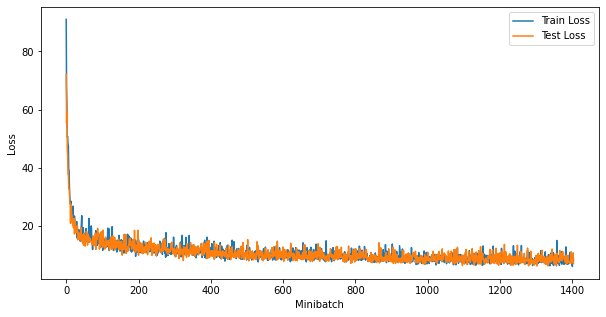

In [13]:
# Plot Loss
fig = plt.figure(facecolor="w", figsize=(10, 5))
plt.plot(loss_hist)
plt.plot(test_loss_hist)
plt.legend(["Train Loss", "Test Loss"])
plt.xlabel("Minibatch")
plt.ylabel("Loss")
plt.show()

Taking a look at the training / test loss, the process is somewhat noisy. This could be a result of a variety of things: minibatch gradient descent is the obvious one, but the use of improper targets likely also contributes. By encouraging the correct class to fire at every time step, the loss function conflicts with the reset mechanism that tries to prevent this.

## 6.2 Test Set Accuracy
This function iterates over all minibatches to obtain a measure of accuracy over the full 10,000 samples in the test set.

In [14]:
total = 0
correct = 0

# drop_last switched to False to keep all samples
test_loader = DataLoader(mnist_test, batch_size=batch_size, shuffle=True, drop_last=False)

with torch.no_grad():
  net.eval()
  for data in test_loader:
    images, labels = data
    images = images.to(device)
    labels = labels.to(device)

    # If current batch matches batch_size, just do the usual thing
    if images.size()[0] == batch_size:
      outputs, _ = net(images.view(batch_size, -1))

    # If current batch does not match batch_size (i.e., is the final batch),
    # modify batch_size in a temp variable and restore it at the end
    else:
      temp_bs = batch_size
      batch_size = images.size()[0]
      outputs, _ = net(images.view(images.size()[0], -1))
      batch_size = temp_bs

    _, predicted = outputs.sum(dim=0).max(1)
    total += labels.size(0)
    correct += (predicted == labels).sum().item()

print(f"Total correctly classified test set images: {correct}/{total}")
print(f"Test Set Accuracy: {100 * correct / total}%")

Total correctly classified test set images: 9628/10000
Test Set Accuracy: 96.28%


Voila! That's it for static MNIST. Feel free to tweak the network parameters, hyperparameters, decay rate, using a learning rate scheduler etc. to see if you can improve the network performance. 

# 7. Spiking MNIST Using a Convolutional SNN

Part of the appeal of SNNs is their ability to handle time-varying spiking data. So let's use rate-coding to convert MNIST into spiking MNIST using the `spikegen` module in the previous tutorial. We will then define a convolutional neural network (CNN) and train that instead. 

In [15]:
from snntorch import spikegen

# MNIST to spiking-MNIST
spike_data, spike_targets = spikegen.rate(data_it, targets_it, num_outputs=num_outputs, num_steps=num_steps)

## 7.1 Visualiser
As a quick refresher from Tutorial 1, let's see what our input data looks like using `spikeplot.animate`. 

In [16]:
from snntorch import spikeplot as splt
from IPython.display import HTML

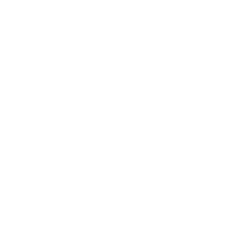

In [17]:
spike_data_sample = spike_data[:, 0, 0]

fig, ax = plt.subplots()
anim = splt.animator(spike_data_sample, fig, ax)

HTML(anim.to_html5_video())

In [18]:
print(spike_targets[0])

tensor(6, device='cuda:0')


## 7.2 Define Convolutional Neural Network
The network is almost entirely the same as for static MNIST. The only difference now is we must iterate through the time dimension of the input, which is achieved using the following line within the for-loop: 

`cur1 = self.fc1(x[step])`

In [39]:
# Define Network
class Net(nn.Module):
    def __init__(self):
        super().__init__()

        # Initialize layers
        self.fc1 = nn.Linear(num_inputs, num_hidden)
        self.lif1 = snn.Stein(alpha=alpha, beta=beta)
        self.fc2 = nn.Linear(num_hidden, num_outputs)
        self.lif2 = snn.Stein(alpha=alpha, beta=beta)

    def forward(self, x):

        # Initialize hidden states and outputs at t=0
        spk1, syn1, mem1 = self.lif1.init_stein(batch_size, num_hidden)
        spk2, syn2, mem2 = self.lif2.init_stein(batch_size, num_outputs)
        
        # Record the final layer
        spk2_rec = []
        mem2_rec = []

        for step in range(num_steps):
            cur1 = self.fc1(x[step])  # Iterate through each time step of input
            spk1, syn1, mem1 = self.lif1(cur1, syn1, mem1)
            cur2 = self.fc2(spk1)
            spk2, syn2, mem2 = self.lif2(cur2, syn2, mem2)

            spk2_rec.append(spk2)
            mem2_rec.append(mem2)

        return torch.stack(spk2_rec, dim=0), torch.stack(mem2_rec, dim=0)

net = Net().to(device)

## 7.3 Training
We make a slight modification to our print-out functions to handle the new first dimension of the input:

In [ ]:
def print_batch_accuracy(data, targets, train=False):
    output, _ = net(data.view(num_steps, batch_size, -1))
    _, idx = output.sum(dim=0).max(1)
    acc = np.mean((targets == idx).detach().cpu().numpy())

    if train:
        print(f"Train Set Accuracy: {acc}")
    else:
        print(f"Test Set Accuracy: {acc}")

def train_printer():
    print(f"Epoch {epoch}, Minibatch {minibatch_counter}")
    print(f"Train Set Loss: {loss_hist[counter]}")
    print(f"Test Set Loss: {test_loss_hist[counter]}")
    print_batch_accuracy(spike_data, spike_targets, train=True)
    print_batch_accuracy(test_spike_data, test_spike_targets, train=False)
    print("\n")


### 7.1 Optimizer & Loss
We'll keep our optimizer and loss the exact same as the static MNIST case.

In [ ]:
optimizer = torch.optim.Adam(net.parameters(), lr=2e-4, betas=(0.9, 0.999))
log_softmax_fn = nn.LogSoftmax(dim=-1)
loss_fn = nn.NLLLoss()

### 7.2 Training Loop
The training loop is identical to the static MNIST case, but we pass each minibatch through `spikegen.rate` before running it through the feedforward network.

In [ ]:
loss_hist = []
test_loss_hist = []
counter = 0

# Outer training loop
for epoch in range(3):
    minibatch_counter = 0
    data = iter(train_loader)

    # Minibatch training loop
    for data_it, targets_it in data:
        data_it = data_it.to(device)
        targets_it = targets_it.to(device)

        # Spike generator
        spike_data, spike_targets = spikegen.rate(data_it, targets_it, num_outputs=num_outputs, num_steps=num_steps,
                                                  gain=1, offset=0, convert_targets=False, temporal_targets=False)

        # Forward pass
        output, mem_rec = net(spike_data.view(num_steps, batch_size, -1))
        log_p_y = log_softmax_fn(mem_rec)
        loss_val = torch.zeros((1), dtype=dtype, device=device)

        # Sum loss over time steps to perform BPTT
        for step in range(num_steps):
          loss_val += loss_fn(log_p_y[step], targets_it)

        # Gradient Calculation
        optimizer.zero_grad()
        loss_val.backward(retain_graph=True)
        nn.utils.clip_grad_norm_(net.parameters(), 1)

        # Weight Update
        optimizer.step()

        # Store Loss history
        loss_hist.append(loss_val.item())

        # Test set
        test_data = itertools.cycle(test_loader)
        testdata_it, testtargets_it = next(test_data)
        testdata_it = testdata_it.to(device)
        testtargets_it = testtargets_it.to(device)

        # Test set spike conversion
        test_spike_data, test_spike_targets = spikegen.rate(testdata_it, testtargets_it, num_outputs=num_outputs,
                                                            num_steps=num_steps, gain=1, offset=0, convert_targets=False, temporal_targets=False)

        # Test set forward pass
        test_output, test_mem_rec = net(test_spike_data.view(num_steps, batch_size, -1))

        # Test set loss
        log_p_ytest = log_softmax_fn(test_mem_rec)
        log_p_ytest = log_p_ytest.sum(dim=0)
        loss_val_test = loss_fn(log_p_ytest, test_spike_targets)
        test_loss_hist.append(loss_val_test.item())

        # Print test/train loss/accuracy
        if counter % 50 == 0:
            train_printer()
        minibatch_counter += 1
        counter += 1

loss_hist_true_grad = loss_hist
test_loss_hist_true_grad = test_loss_hist

## 8. Spiking MNIST Results
### 8.1 Plot Training/Test Loss

In [ ]:
# Plot Loss
fig = plt.figure(facecolor="w", figsize=(10, 5))
plt.plot(loss_hist)
plt.plot(test_loss_hist)
plt.legend(["Test Loss", "Train Loss"])
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.show()

### 8.2 Test Set Accuracy

In [ ]:
total = 0
correct = 0
test_loader = DataLoader(mnist_test, batch_size=batch_size, shuffle=True, drop_last=False)

with torch.no_grad():
  net.eval()
  for data in test_loader:
    images, labels = data
    images = images.to(device)
    labels = labels.to(device)

    # If current batch matches batch_size, just do the usual thing
    if images.size()[0] == batch_size:
      spike_test, spike_targets = spikegen.rate(images, labels, num_outputs=num_outputs, num_steps=num_steps,
                                                            gain=1, offset=0, convert_targets=False, temporal_targets=False)

      outputs, _ = net(spike_test.view(num_steps, batch_size, -1))

    # If current batch does not match batch_size (e.g., is the final minibatch),
    # modify batch_size in a temp variable and restore it at the end of the else block
    else:
      temp_bs = batch_size
      batch_size = images.size()[0]
      spike_test, spike_targets = spikegen.rate(images, labels, num_outputs=num_outputs, num_steps=num_steps,
                                                gain=1, offset=0, convert_targets=False, temporal_targets=False)

      outputs, _ = net(spike_test.view(num_steps, images.size()[0], -1))
      batch_size = temp_bs

    _, predicted = outputs.sum(dim=0).max(1)
    total += spike_targets.size(0)
    correct += (predicted == spike_targets).sum().item()

print(f"Total correctly classified test set images: {correct}/{total}")
print(f"Test Set Accuracy: {100 * correct / total}%")

That's all for now!
Next time, we'll introduce how to use spiking convolutional layers to improve accuracy.